In [1]:
%matplotlib inline

from ultralytics import YOLO
import os
import yaml
import sys
from matplotlib import pyplot as plt
from math import ceil
import numpy as np
import seaborn as sns
import cv2

sys.path.append("..")
from dev.display import draw_yolo_boxes
from src.processing.consts import DATASET_BASE_PATH
from train.yolo import show_gt_and_pred, read_ground_truth
from dev.utils import print_results_yolo, get_fp_fn_images, save_img_and_log

In [2]:
MODEL_PATH = "../models/sea-form8_sea_aug-random_best.pt"
CONFIDENCE = 0.3
OUT_PATH = "../out/summary"

ONE_CLASS_DIR = "one_class"
TWO_CLASS_DIR = "two_classes"
PILE_DIR = "pile_only"
LITTER_DIR = "litter_only"

DATASET = {
    "name": "hamburg mapping N G form8",
    "dataset_path": f"{DATASET_BASE_PATH}/created/hamburg_mapping-form8-val",
    "config_name": "hamburg_mapping-form8-val.yaml",
    "output_dir": f"{OUT_PATH}/{MODEL_PATH.split('/')[-1].split('.')[0]}"
}

DATASET_INV = {
    "name": "hamburg mapping form8 G N (inverse)",
    "dataset_path": f"{DATASET_BASE_PATH}/created/hamburg_mapping-inverse-form8-val",
    "config_name": "hamburg_mapping-inverse-form8-val.yaml",
    "output_dir": f"{OUT_PATH}/{MODEL_PATH.split('/')[-1].split('.')[0]}"
}

DATASETS = [DATASET, DATASET_INV]

In [3]:
for dataset in DATASETS:
    os.makedirs(dataset["output_dir"], exist_ok=True)

In [4]:
def change_labels(dataset_path, dir):
    !rm -rf {dataset_path}/labels
    !ln -s {dataset_path}/{dir} {dataset_path}/labels
    print(f"labels changed to {dir}")

# SHOW ANNOTATIONS

In [5]:
def show_annotations(dataset_path, config_name, output_dir, filename, all_channels=False):
    for split in ("train", "val", "test"):
        if not os.path.exists(f"{dataset_path}/images/{split}"):
            print(f"Images directory for {split} does not exist in {dataset_path}/images/")
            continue
        files = os.listdir(f"{dataset_path}/images/{split}")
        if len(files) == 0:
            print(f"No images found in {dataset_path}/images/{split}")
            continue

        if not all_channels:
            # RGB or channel 0 only
            rgb_files = [f for f in files if f.endswith(('_RGB.png'))]
            files = rgb_files if rgb_files else [f for f in files if f.endswith(('_ch0.tif', '_ch0.tiff'))]

            if len(files) == 0:
                print(f"No image with RGB or channel 0 found in {dataset_path}/images/{split}")
                continue

        files.sort()

        n_cols = 7 if len(files) > 7 else len(files)
        n_rows = ceil(len(files) / n_cols)

        fig, axs = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols*4, n_rows*3))

        with open(f"{dataset_path}/{config_name}", "r") as file:
            config = yaml.safe_load(file)

        for fn, ax in zip(files, axs.flatten()):
            ax.set_title(fn)
            ax.axis("off")
            image, annots = draw_yolo_boxes(f"{dataset_path}/images/{split}/{fn}", 
                            f"{dataset_path}/labels/{split}/{os.path.splitext(fn)[0] + '.txt'}",
                            config["names"], display=False)
            ax.imshow(image)

        plt.tight_layout()
        plt.savefig(f"{output_dir}/{filename}_annots-{split}.jpg")
        plt.close()

        print(f"Saved annotations for {split} to {output_dir}/{filename}_annots-{split}.jpg")

In [ ]:
ds_names = ["mandrac0",  "mandrac1", "mandrac2", "mandrac3", "hamburg_mapping","hamburg_pile", "mandrac_no_litter", "hamburg_no_litter"]
dataset_paths = [f"{DATASET_BASE_PATH}/annotated/{ds}" for ds in ds_names]

for dataset_path, name in zip(dataset_paths, ds_names):
    show_annotations(dataset_path, "data_config.yaml", OUT_PATH, f"{name}")

Saved annotations for train to ../out/summary/mandrac0.jpg
No images found in /home/anna/Datasets//annotated/mandrac0/images/val
Images directory for test does not exist in /home/anna/Datasets//annotated/mandrac0/images/
Saved annotations for train to ../out/summary/mandrac1.jpg
Images directory for val does not exist in /home/anna/Datasets//annotated/mandrac1/images/
Images directory for test does not exist in /home/anna/Datasets//annotated/mandrac1/images/
Saved annotations for train to ../out/summary/mandrac2.jpg
Images directory for val does not exist in /home/anna/Datasets//annotated/mandrac2/images/
Images directory for test does not exist in /home/anna/Datasets//annotated/mandrac2/images/
Saved annotations for train to ../out/summary/mandrac3.jpg
Images directory for val does not exist in /home/anna/Datasets//annotated/mandrac3/images/
Images directory for test does not exist in /home/anna/Datasets//annotated/mandrac3/images/
Saved annotations for train to ../out/summary/hamburg

In [8]:
show_annotations(f"{DATASET_BASE_PATH}/created/test/", "test.yaml", OUT_PATH, "aug_test", all_channels=True)

Saved annotations for train to ../out/summary/aug_test_annots-train.jpg
Saved annotations for val to ../out/summary/aug_test_annots-val.jpg
Saved annotations for test to ../out/summary/aug_test_annots-test.jpg


In [7]:
show_annotations(f"{DATASET_BASE_PATH}/created/mandrac-hamburg_form8_random-sub/" , "mandrac-hamburg_form8_random-sub.yaml", OUT_PATH, "mandrac-hamburg_form8_random-sub", all_channels=True)

Saved annotations for train to ../out/summary/mandrac-hamburg_form8_random-sub_annots-train.jpg
Saved annotations for val to ../out/summary/mandrac-hamburg_form8_random-sub_annots-val.jpg
Saved annotations for test to ../out/summary/mandrac-hamburg_form8_random-sub_annots-test.jpg


In [ ]:
dataset = DATASET

change_labels(dataset["dataset_path"], TWO_CLASS_DIR)
show_annotations(dataset["dataset_path"], dataset["config_name"], dataset['output_dir'], {dataset["dataset_path"].split('/')[-1]})

# Evaluate model

In [9]:
def save_images(pred_results, dataset, title=""):
    # save gt and pred images
    change_labels(dataset['dataset_path'], TWO_CLASS_DIR)
    gt, classes = read_ground_truth(pred_results)
    image = show_gt_and_pred(pred_results, gt, n_cols=6, gt_classes=classes, show_empty=False)
    fp_image, fn_image = get_fp_fn_images(pred_results, CONFIDENCE)

    output_dir = dataset['output_dir']
    save_img_and_log(image, f"{output_dir}/preds-gt_{title.replace(' ', '-')}_conf-{CONFIDENCE}.jpg")
    save_img_and_log(fp_image, f"{output_dir}/fps_{title.replace(' ', '-')}_conf-{CONFIDENCE}.jpg")
    save_img_and_log(fn_image, f"{output_dir}/fns_{title.replace(' ', '-')}_conf-{CONFIDENCE}.jpg")

def evaluate_model(model, dataset, names):
    ds_path = dataset['dataset_path']
    label_dirs = [ONE_CLASS_DIR, PILE_DIR, LITTER_DIR]
    for label_dir, name in zip(label_dirs, names):
        change_labels(ds_path, label_dir)
        val_results = model.val(data=f"{ds_path}/{dataset['config_name']}", plots=True, verbose=False)
        pred_results = model.predict(source=f"{ds_path}/images/val", save=False, conf=CONFIDENCE, verbose=False)

        print_results_yolo(val_results, name)
        save_images(pred_results, dataset, name)

In [10]:
model = YOLO(MODEL_PATH)

EVALUATING MODEL ON N G form8 DATASET
labels changed to one_class
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)
YOLOv10n summary (fused): 285 layers, 2,694,806 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 166 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


                   all        317        435      0.191      0.117      0.049     0.0297
Speed: 1.5ms preprocess, 101.8ms inference, 0.0ms loss, 0.1ms postprocess per image
Results saved to runs/detect/val13

ALL PRESENT LITTER VALIDATION RESULTS 
Results:
mAP50: 0.049
mAP50-95: 0.030
Precision: 0.191
Recall: 0.117
F1: 0.145


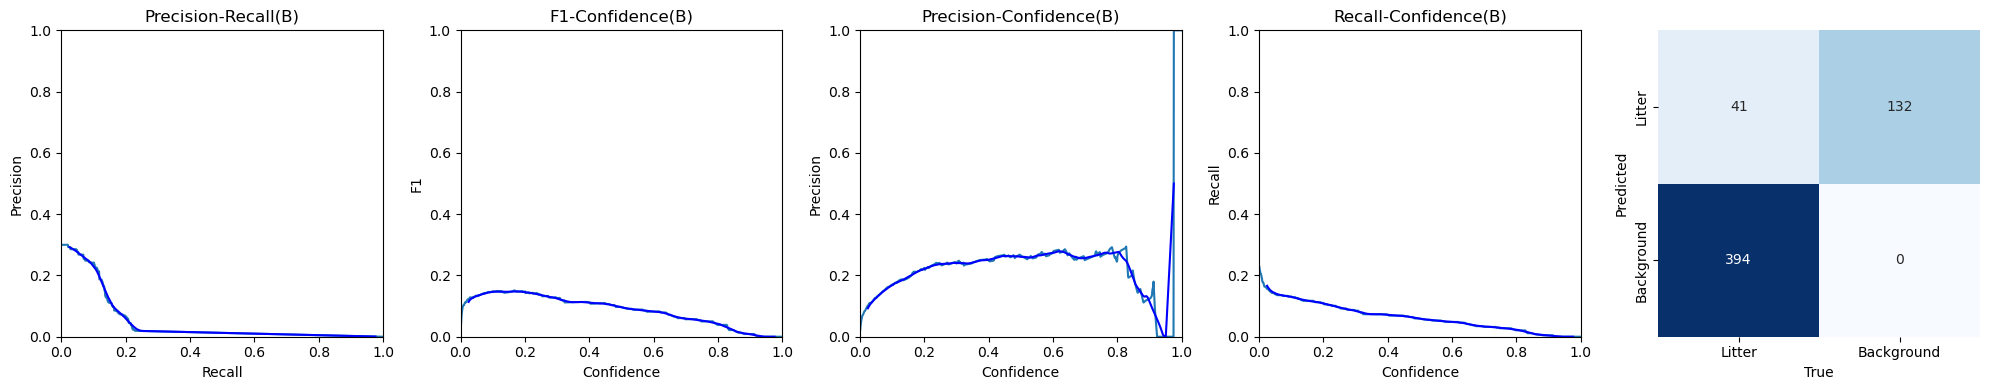

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0124_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0164_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0165_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0166_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0167_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0185_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0194_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0204_15_N

val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 279 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:41<00:00,  2.08s/it]


                   all        317         38       0.19      0.605      0.191      0.137
Speed: 1.8ms preprocess, 111.5ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/val14

ONLY OUR LITTER VALIDATION RESULTS 
Results:
mAP50: 0.191
mAP50-95: 0.137
Precision: 0.190
Recall: 0.605
F1: 0.289


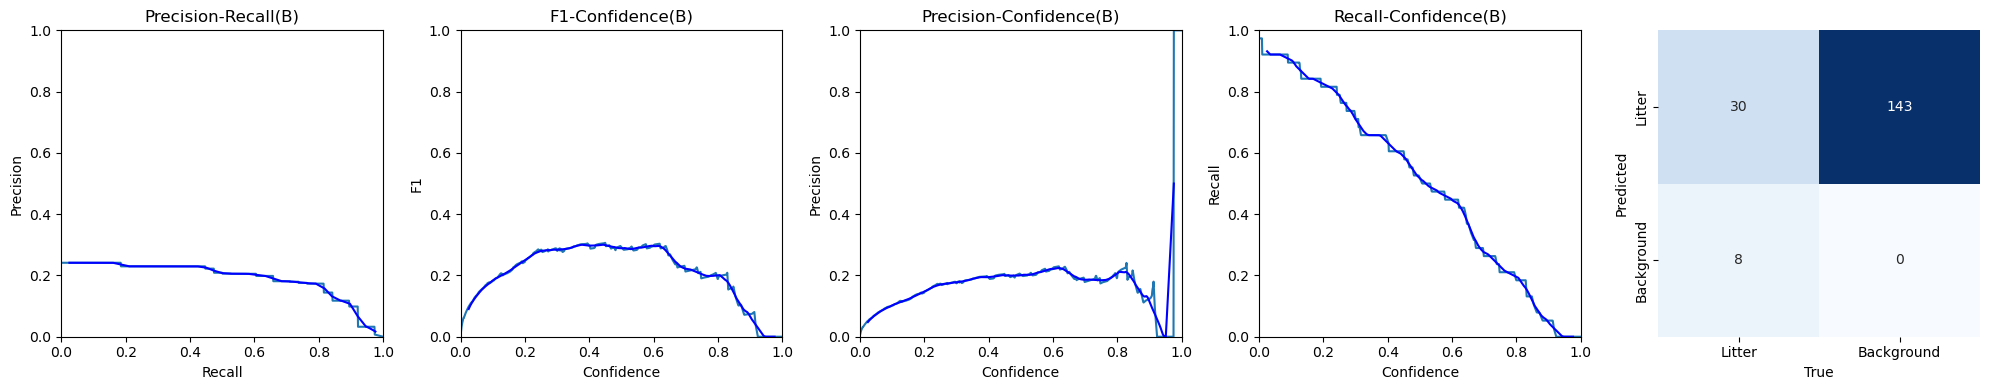

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0124_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0164_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0165_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0166_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0167_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0185_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0194_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0204_15_N

val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache... 317 images, 184 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:47<00:00,  2.36s/it]


                   all        317        397      0.057     0.0605      0.014    0.00695
Speed: 1.7ms preprocess, 130.3ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val15

ONLY PRESENT LITTER VALIDATION RESULTS 
Results:
mAP50: 0.014
mAP50-95: 0.007
Precision: 0.057
Recall: 0.060
F1: 0.059


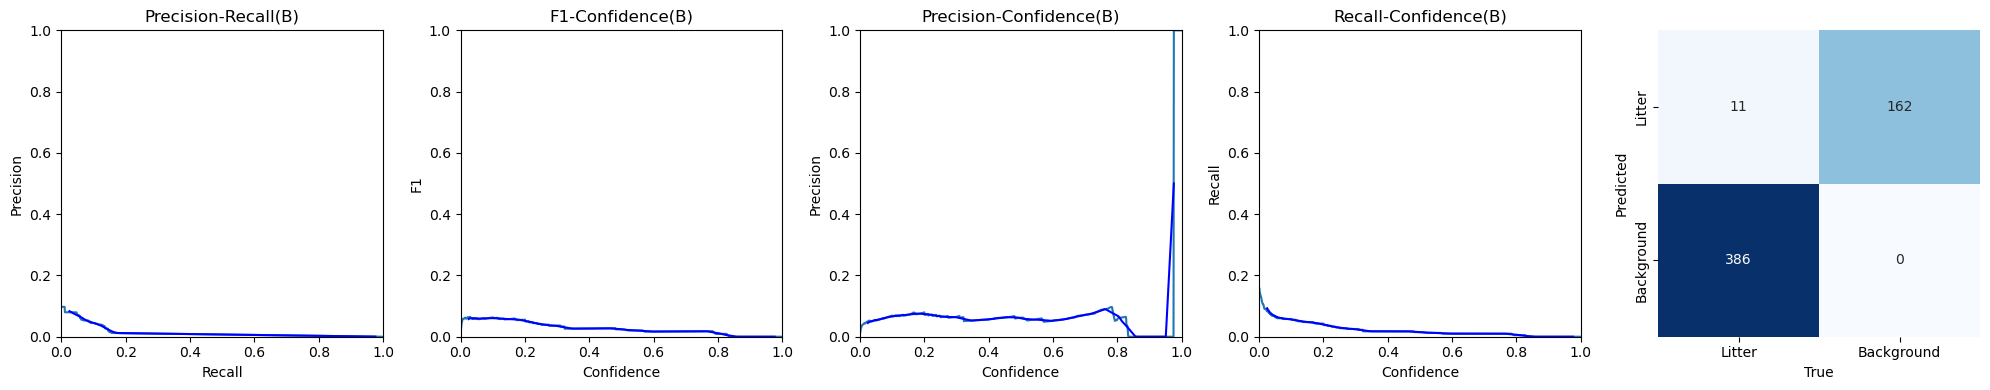

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0124_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0164_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0165_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0166_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0167_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0185_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0194_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0204_15_N

In [11]:
print("EVALUATING MODEL ON N G form8 DATASET")
evaluate_model(model, DATASET, ["all present litter", "only our litter", "only present litter"])

EVALUATING MODEL ON form8 G N DATASET
labels changed to one_class
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/labels/val... 317 images, 166 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:01<00:00, 185.82it/s]

val: New cache created: /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:41<00:00,  2.06s/it]


                   all        317        435      0.296     0.0943      0.058     0.0364
Speed: 1.9ms preprocess, 110.9ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/val16

ALL PRESENT LITTER (INVERSE) VALIDATION RESULTS 
Results:
mAP50: 0.058
mAP50-95: 0.036
Precision: 0.296
Recall: 0.094
F1: 0.143


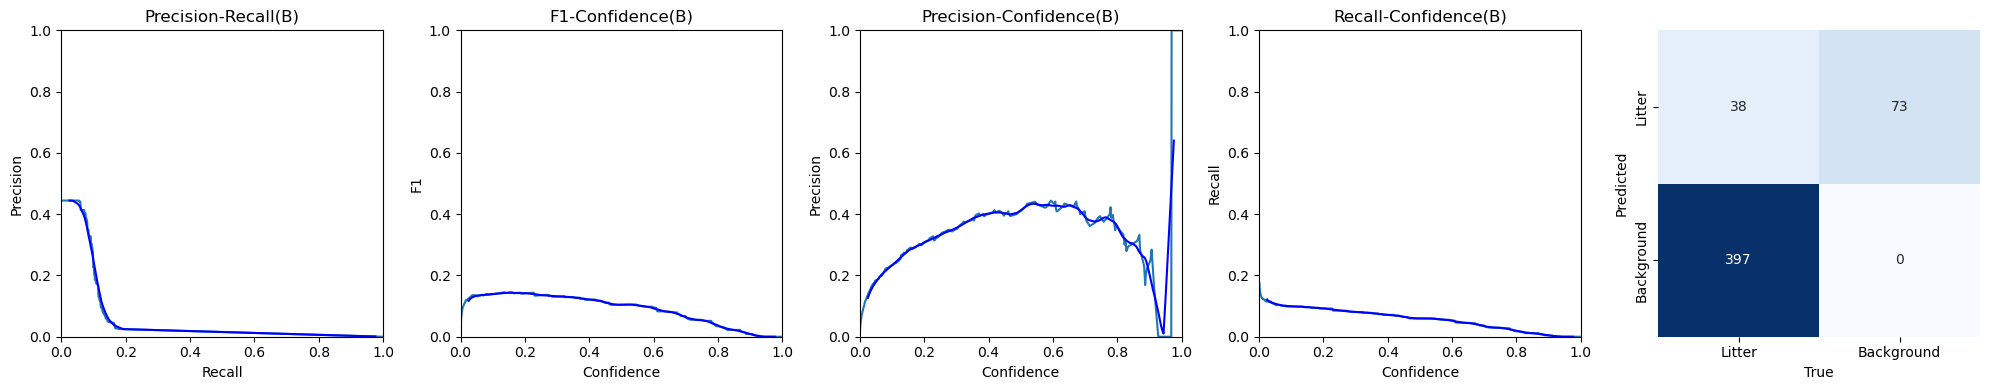

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0124_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0164_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0165_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0166_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0167_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-5

val: Scanning /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/labels/val... 317 images, 279 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:01<00:00, 291.15it/s]

val: New cache created: /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:34<00:00,  1.74s/it]


                   all        317         38       0.34      0.684      0.352      0.256
Speed: 1.6ms preprocess, 94.0ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs/detect/val17

ONLY OUR LITTER (INVERSE) VALIDATION RESULTS 
Results:
mAP50: 0.352
mAP50-95: 0.256
Precision: 0.340
Recall: 0.684
F1: 0.454


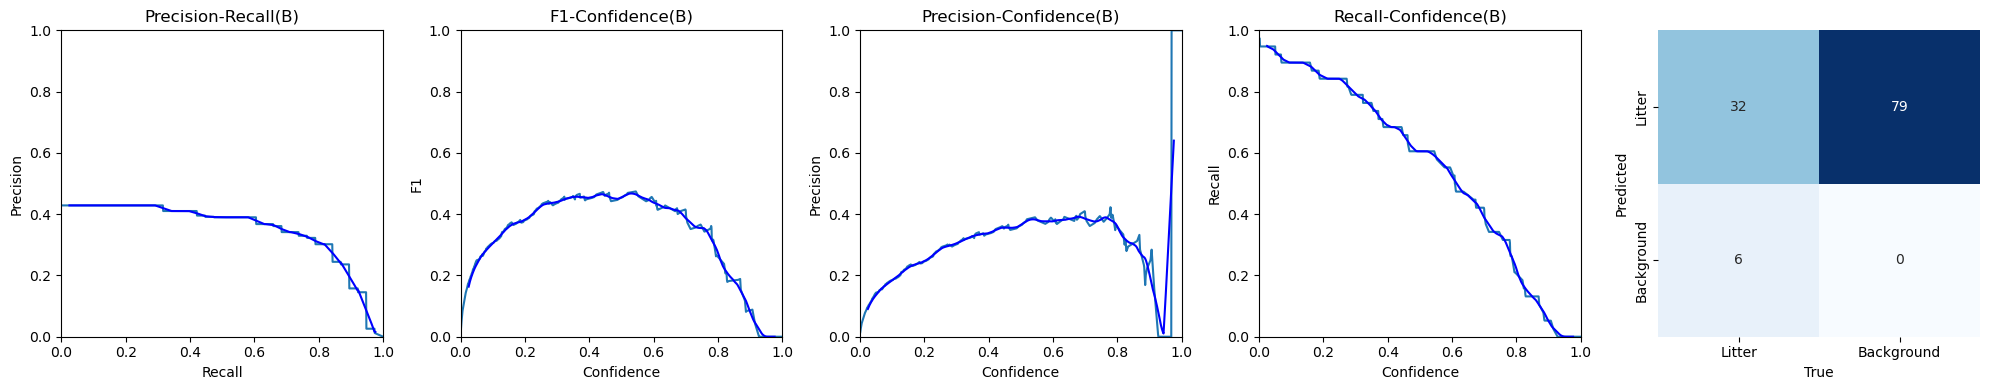

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0124_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0164_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0165_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0166_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0167_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-5

val: Scanning /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/labels/val... 317 images, 184 backgrounds, 0 corrupt: 100%|██████████| 317/317 [00:01<00:00, 240.89it/s]

val: New cache created: /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 20/20 [00:34<00:00,  1.73s/it]


                   all        317        397     0.0408     0.0252    0.00965    0.00442
Speed: 1.4ms preprocess, 94.5ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val18

ONLY PRESENT LITTER (INVERSE) VALIDATION RESULTS 
Results:
mAP50: 0.010
mAP50-95: 0.004
Precision: 0.041
Recall: 0.025
F1: 0.031


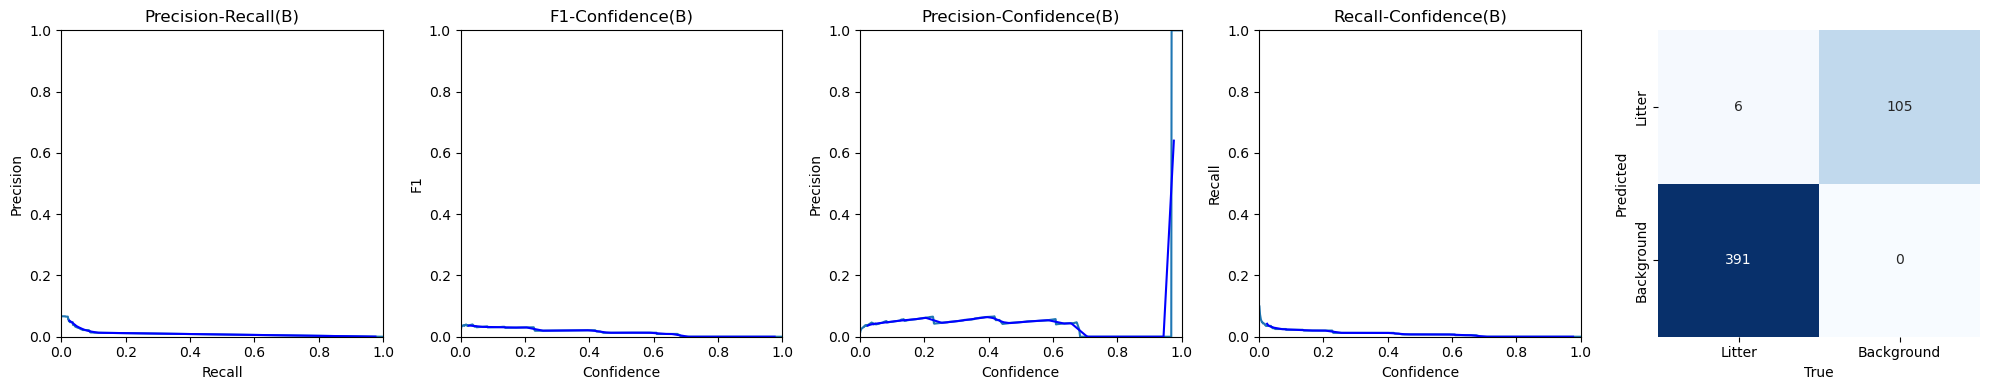

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0124_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0164_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0165_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0166_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-50-16_0167_15_(N-(E-N))_G_N.png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-inverse-form8-val/images/val/1047541_dataset 2025-06-04 10-5

In [12]:
print("EVALUATING MODEL ON form8 G N DATASET")
evaluate_model(model, DATASET_INV, ["all present litter (inverse)", "only our litter (inverse)", "only present litter (inverse)"])

EVALUATING MODEL ON N G form8 DATASET WITHOUT THE SHORE
labels changed to one_class
Ultralytics 8.3.74 🚀 Python-3.8.20 torch-2.4.1+cu121 CPU (13th Gen Intel Core(TM) i7-13700H)


val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val... 256 images, 162 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:00<00:00, 290.28it/s]

val: New cache created: /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:39<00:00,  2.47s/it]


                   all        256        162      0.246      0.296      0.124     0.0751
Speed: 1.7ms preprocess, 138.6ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val22

ALL PRESENT LITTER (NO SHORE) VALIDATION RESULTS 
Results:
mAP50: 0.124
mAP50-95: 0.075
Precision: 0.246
Recall: 0.296
F1: 0.269


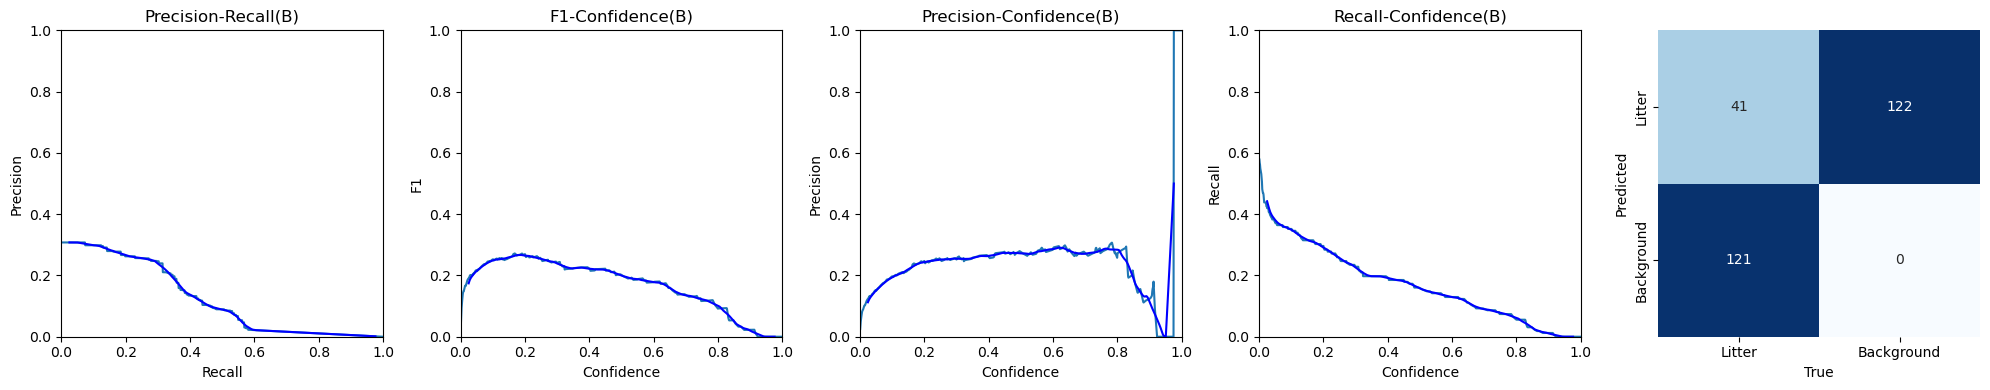

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0167_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0185_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0194_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0204_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0205_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0206_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0207_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0208_15_N

val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val... 256 images, 218 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:00<00:00, 258.88it/s]

val: New cache created: /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:28<00:00,  1.76s/it]


                   all        256         38      0.203      0.638      0.199      0.143
Speed: 1.4ms preprocess, 93.2ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val23

ONLY OUR LITTER (NO SHORE) VALIDATION RESULTS 
Results:
mAP50: 0.199
mAP50-95: 0.143
Precision: 0.203
Recall: 0.638
F1: 0.308


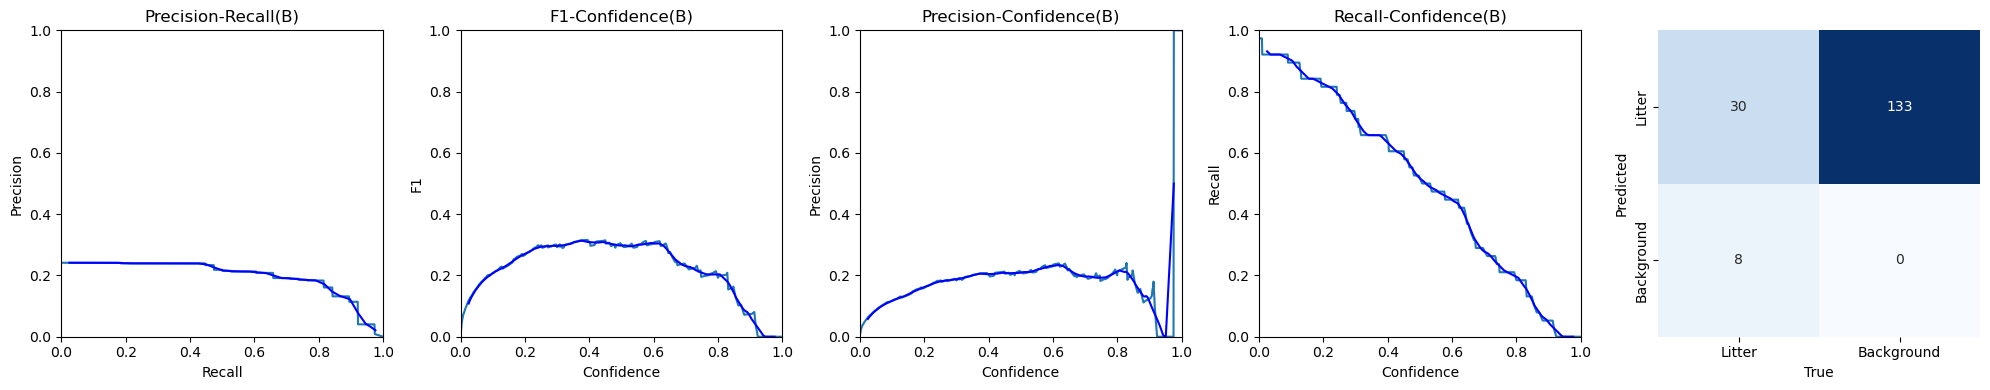

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0167_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0185_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0194_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0204_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0205_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0206_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0207_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0208_15_N

val: Scanning /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val... 256 images, 180 backgrounds, 0 corrupt: 100%|██████████| 256/256 [00:01<00:00, 185.20it/s]

val: New cache created: /home/anna/Datasets/created/hamburg_mapping-form8-val/labels/val.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [00:27<00:00,  1.73s/it]


                   all        256        124     0.0794      0.161     0.0346     0.0168
Speed: 1.3ms preprocess, 91.9ms inference, 0.0ms loss, 0.3ms postprocess per image
Results saved to runs/detect/val24

ONLY PRESENT LITTER (NO SHORE) VALIDATION RESULTS 
Results:
mAP50: 0.035
mAP50-95: 0.017
Precision: 0.079
Recall: 0.161
F1: 0.106


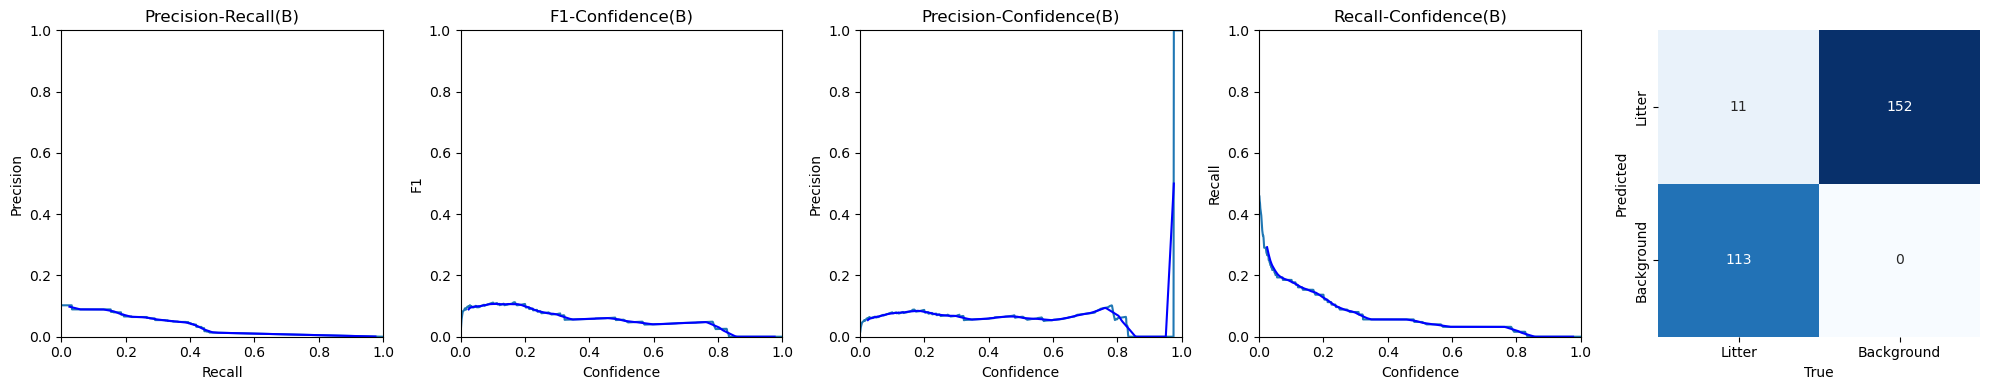

labels changed to two_classes
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0167_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0185_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0194_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0204_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0205_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0206_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0207_15_N_G_(N-(E-N)).png. Skipping...
No boxes present for /home/anna/Datasets/created/hamburg_mapping-form8-val/images/val/0208_15_N

In [14]:
# Manually move images to 167 to different directory
print("EVALUATING MODEL ON N G form8 DATASET WITHOUT THE SHORE")
evaluate_model(model, DATASET, ["all present litter (no shore)", "only our litter (no shore)", "only present litter (no shore)"])

In [ ]:
from micasense import capture

from src.processing.consts import DATASET_BASE_PATH
from src.main_drone import get_image_from_camera
from src.main_ground import send_outcomes

import micasense.capture as capture
from src.processing.load import align_from_saved_matrices, find_images, get_irradiance, load_all_warp_matrices
from src.shapes import Rectangle
from src.utils import greedy_grouping, prepare_image

paths = [f"{DATASET_BASE_PATH}/raw_images/hamburg_2025_05_19/images/0000SET/002/IMG_0422_{i}.tif" for i in range(1, 6)]
panel_path = [f"{DATASET_BASE_PATH}/raw_images/temp_panel/IMG_0000_{i}.tiff" for i in range(0, 5)]
warp_matrices_dir = f"{DATASET_BASE_PATH}/annotated/warp_matrices"
altitude = 15
warp_matrices = load_all_warp_matrices(warp_matrices_dir)
formula = "(N - (E - N))"
channels = ["N", "G", formula]
is_complex = False
new_image_size = (800, 608)
original_image_size = (1456, 1088)

img_capt = capture.Capture.from_filelist(paths)
panel_capt = capture.Capture.from_filelist(panel_path)
img_type = get_irradiance(img_capt, panel_capt, display=False, vignetting=False)
img_aligned = align_from_saved_matrices(img_capt, img_type, warp_matrices, altitude, allow_closest=True, reference_band=0)
image = prepare_image(img_aligned, channels, is_complex, new_image_size)

plt.imshow(image)

image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
results = model.predict(source=image, save=False, verbose=False)
results[0].show()